In [1]:
from datetime import datetime
start_time = datetime.now().strftime('%H:%M:%S')
print('Start time:', start_time)

Start time: 00:24:46


In [2]:
import MetaTrader5 as mt5

import numpy as np

from matplotlib import dates #weekmonthdaylocater

import mplfinance as fplt  #chart 

from pandas.tseries.offsets import BDay


# MetaTrader 5 paketi ile ilgili verileri görüntüle
print("MetaTrader5 package author: ",mt5.__author__)
print("MetaTrader5 package version: ",mt5.__version__)
 
# elde edilen verileri tablo şeklinde görüntülemek için 'pandas' modülünü içe aktar
import pandas as pd
pd.set_option('display.max_columns', 500) # görüntülenecek sütun sayısı
pd.set_option('display.width', 1500)      # görüntülenecek maksimum tablo genişliği
# zaman dilimi ile çalışmak için pytz modülünü içe aktar
import pytz
 
# MetaTrader 5 terminaline bağlantı kur
if not mt5.initialize():
    print("initialize() failed, error code =",mt5.last_error())
    quit()
 
# zaman dilimini UTC olarak ayarla
timezone = pytz.timezone("Etc/UTC")
# yerel zaman dilimi ötelemesinin gerçekleşmesini önlemek için UTC zaman diliminde 'datetime' nesnesi oluştur
#utc_from = datetime(2020, 1, 10, tzinfo=timezone)
utc_from = datetime.now(tz=timezone)
# UTC zaman diliminde 01.10.2020 tarihinden itibaren 10 EURUSD H4 barı elde et
rates = mt5.copy_rates_from("XAUUSD", mt5.TIMEFRAME_D1, utc_from, 1000)
 
# MetaTrader 5 terminaline olan bağlantıyı kapat
mt5.shutdown()
# elde edilen verilerin her bir elemanını yeni bir satırda göster
#print("Elde edilen verileri 'olduğu gibi' görüntüle")
#for rate in rates:
    #print(rate)

# elde edilen verilerden DataFrame oluştur
rates_frame = pd.DataFrame(rates)
# saniye cinsinden zamanı datetime biçimine dönüştür
rates_frame['btime']=pd.to_datetime(rates_frame['time'], unit='s')
rates_frame.set_index('btime', inplace=True)                      

 

MetaTrader5 package author:  MetaQuotes Ltd.
MetaTrader5 package version:  5.0.36


In [3]:
rates_frame.drop(columns= 'time', axis=1 , inplace=True)
rates_frame

,open,high,low,close,tick_volume,spread,real_volume
btime,,,,,,,
2019-07-12,1404.51,1416.84,1403.08,1414.83,53268,15,0
2019-07-15,1416.52,1419.73,1407.63,1413.70,48080,15,0
2019-07-16,1414.44,1418.22,1400.68,1405.82,54713,15,0
2019-07-17,1406.48,1426.75,1400.01,1426.21,51546,15,0
2019-07-18,1426.30,1448.07,1414.56,1445.65,78476,15,0
...,...,...,...,...,...,...,...
2023-05-22,1978.08,1982.59,1968.87,1971.65,119644,5,0
2023-05-23,1971.64,1977.78,1954.24,1975.16,132916,5,0
2023-05-24,1976.20,1985.29,1956.71,1957.59,132332,5,0


In [4]:
rates_frame_copy=rates_frame.copy(deep=True)

Adding Moving Averages

In [5]:
rates_frame_copy['ma_close_10'] = rates_frame_copy['close'].rolling(window=10).mean()
rates_frame_copy['ma_close_20'] = rates_frame_copy['close'].rolling(window=20).mean()
rates_frame_copy['ma_close_50'] = rates_frame_copy['close'].rolling(window=50).mean()
rates_frame_copy['ma_close_100'] = rates_frame_copy['close'].rolling(window=100).mean()
rates_frame_copy['ma_close_200'] = rates_frame_copy['close'].rolling(window=200).mean()

Max Price Chart

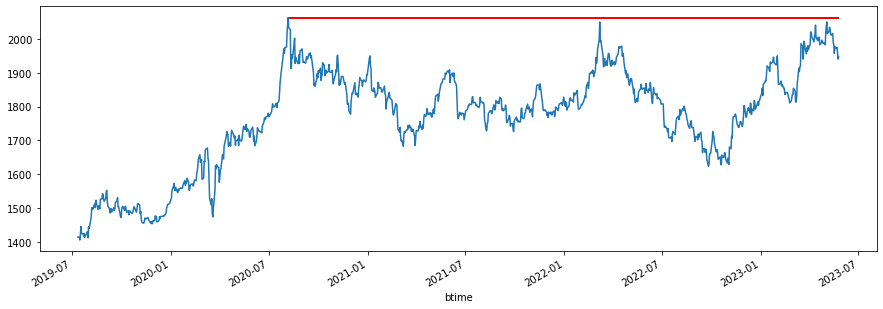

In [6]:
max_price_chart =rates_frame_copy['close'].plot(figsize=(15,5) )
max_price_chart.hlines(y=rates_frame_copy['close'].max(), xmin=rates_frame_copy['close'].idxmax(), xmax=rates_frame_copy['close'].index.max(), color='r', linestyle='-', lw=2)


EMA Calculation

In [7]:
rates_frame_copy['ema_5']=rates_frame_copy['close'].ewm(span=5 , adjust=False).mean()

rates_frame_copy['ema_10']=rates_frame_copy['close'].ewm(span=10 , adjust=False).mean()

rates_frame_copy['ema_20']=rates_frame_copy['close'].ewm(span=20 , adjust=False).mean()

rates_frame_copy['ema_50']=rates_frame_copy['close'].ewm(span=50 , adjust=False).mean()

rates_frame_copy['ema_100']=rates_frame_copy['close'].ewm(span=100 , adjust=False).mean()

rates_frame_copy['ema_200']=rates_frame_copy['close'].ewm(span=200 , adjust=False).mean()


#Average Price
rates_frame_copy['avg_price']= (rates_frame_copy['high'] + rates_frame_copy['low'])/2

<AxesSubplot:xlabel='btime'>

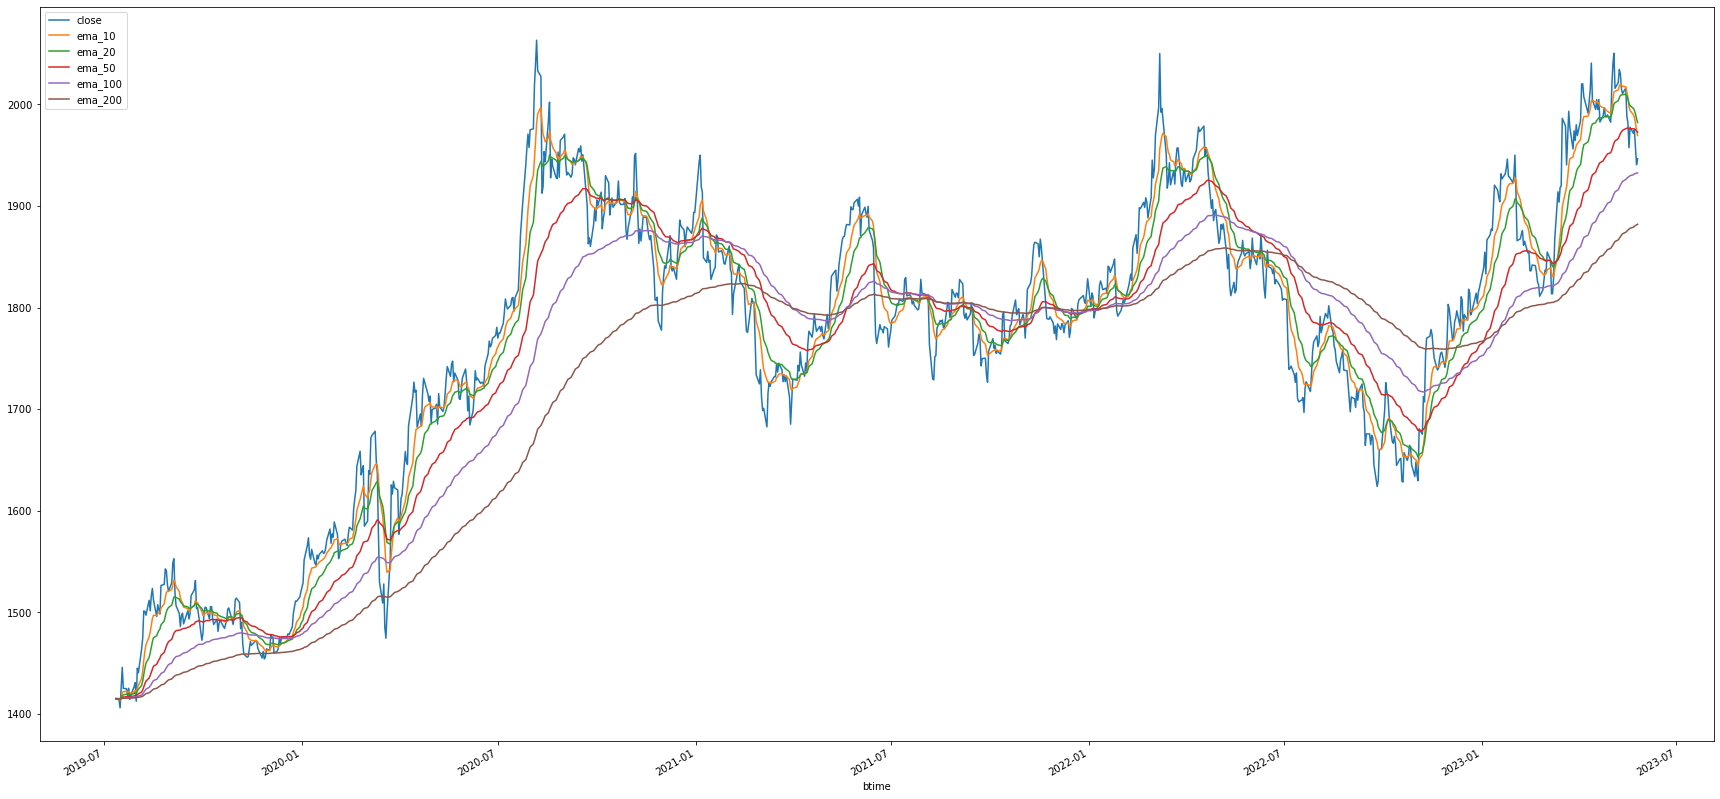

In [8]:
rates_frame_copy[['close','ema_10','ema_20','ema_50','ema_100','ema_200']].plot(figsize=(30,15))

Trend Detection

Elliot Wave

In [9]:
rates_frame_copy['ma_close_5'] = rates_frame_copy['close'].rolling(window=5).mean()
rates_frame_copy['ma_close_35'] = rates_frame_copy['close'].rolling(window=35).mean()

Ellio Wave Pine Script
//@version=5
//@author Koryu
indicator(title = "Elliott Wave Oscillator", shorttitle="EWO")
src = input(close, title="source")
sma1length = input(5)
sma2length = input(35)
UsePercent = input.bool(true, "Show Dif as percent of current Candle") 
smadif= UsePercent ? (ta.sma(src, sma1length) - ta.sma(src, sma2length)) / src * 100 : ta.sma(src, sma1length) - ta.sma(src, sma2length)
col=smadif <= 0 ? color.red : color.green
plot(smadif, color=col, linewidth=2, style=plot.style_histogram)

In [10]:
rates_frame_copy['wave'] = 100 * (rates_frame_copy['ma_close_5'] - rates_frame_copy['ma_close_35'])/rates_frame_copy['close']

In [11]:
rates_frame_copy['wave'].max()

8.51526110614397

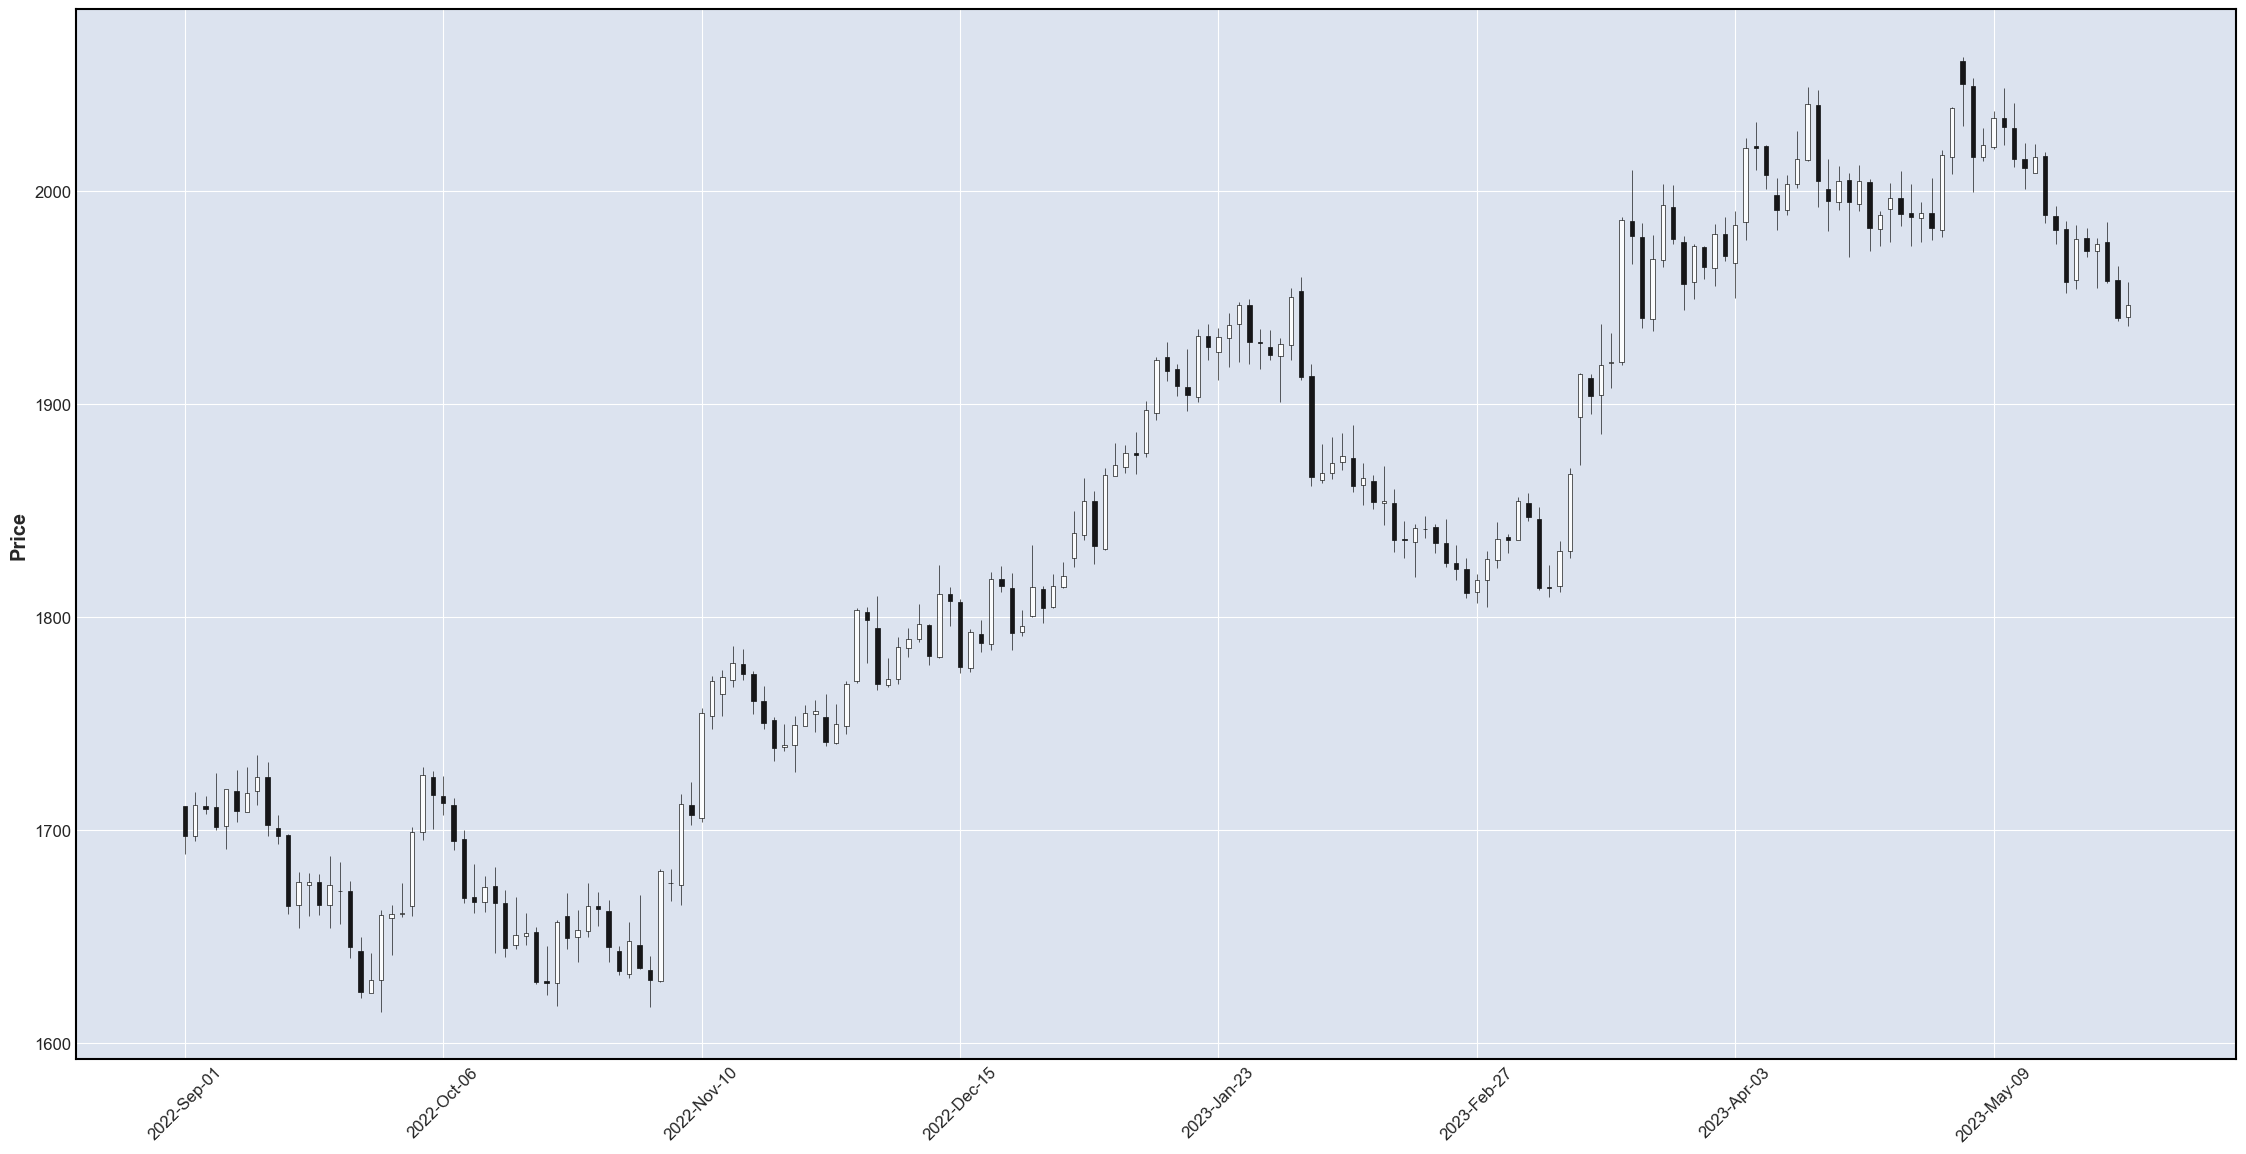

In [12]:
fplt.plot(rates_frame_copy.loc['2022-09-01':,] , type='candle' , figsize=(30,15))

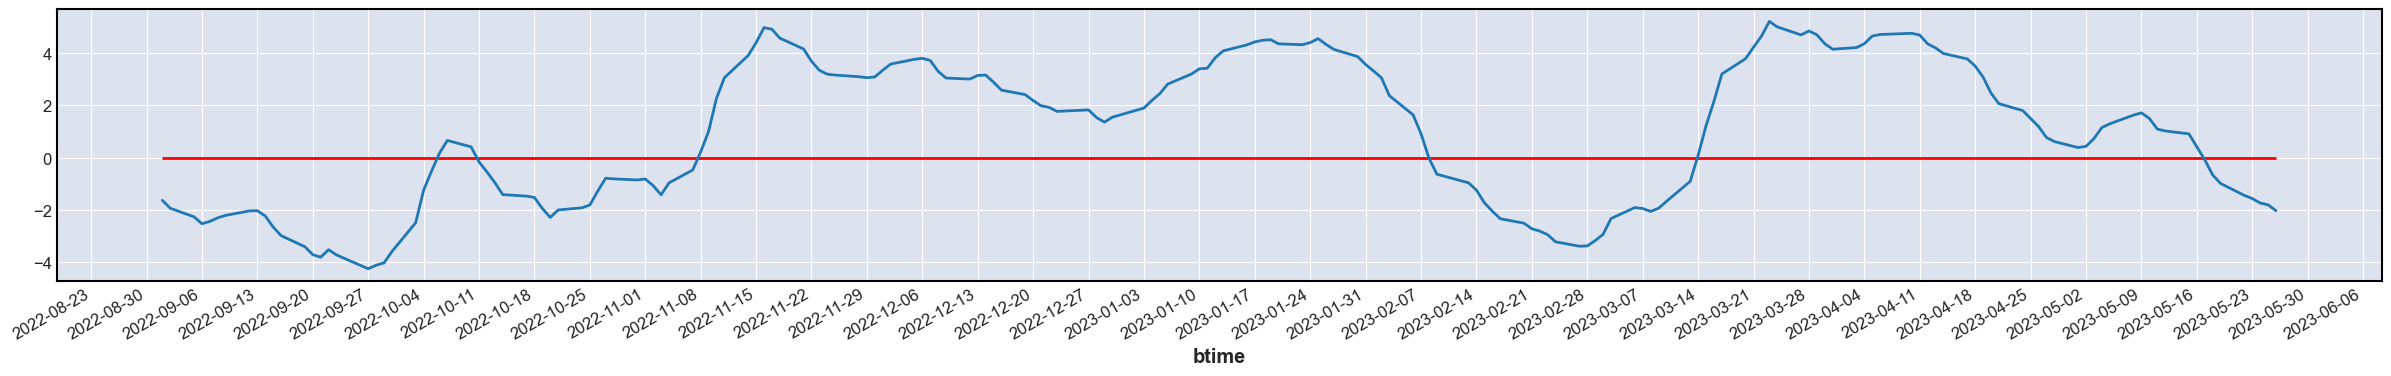

In [13]:
ax = rates_frame_copy.loc['2022-09-01': ,'wave'].plot(figsize=(30,4))
ax.hlines(y = 0, xmin=rates_frame_copy['2022-09-01':].index[0], xmax=rates_frame_copy.index.max(), color='r', linestyle='-', lw=2)
ax.xaxis.set_major_locator(dates.WeekdayLocator())

KARALAMA

ZigZag

In [14]:
class Zigzag:

    def __init__(self, timeseries, swingthresh = 0.05):

        self.timeseries = timeseries
        self.swingthresh = swingthresh 
        self.upswing = None
        self.zigzag = []
        

    def add_row(self, list):

        self.zigzag.append(list)
        self.upswing = True if list[-1] == 'high' else False

    def update_row(self, timestamp, price):

        #uppdates last row
        self.zigzag[-1][0], self.zigzag[-1][1] = timestamp, price

    def first_swing(self):

        lasthigh, lastlow = self.timeseries.iat[0,1], self.timeseries.iat[0,2]
        
        for index, row in self.timeseries.iterrows():

            row_high, row_low = row['high'], row['low']

            high = row['high'] > lastlow + (lastlow * self.swingthresh)
            low = row['low'] < lasthigh - (lasthigh * self.swingthresh)

            if high & low:

                lasthigh = row_high
                lastlow = row_low

            else:

                self.upswing = True if high ==True else False
                return

    def get_swings(self):

        self.first_swing()
 
        lasthigh, lastlow = self.timeseries.iat[0,1], self.timeseries.iat[0,2]

        if self.upswing == True:

            self.add_row([self.timeseries.index[0], lastlow, 'low'])
            self.add_row([self.timeseries.index[0], lasthigh, 'high'])
    
        else:

            self.add_row([self.timeseries.index[0], lasthigh, 'high'])
            self.add_row([self.timeseries.index[0], lastlow, 'low'])
        
        for index, row in self.timeseries.iterrows():

            row_timestamp = index
            row_high = row['high']
            row_low = row['low']

            if self.upswing == True:
                if row_high > lasthigh:

                    self.update_row(index, row_high)
                    lasthigh = row_high

                # if index != self.timeseries.index[0]:
                if row_low <= lasthigh - (lasthigh * self.swingthresh):
                    #if new swinglow, add new row
                    self.add_row([row_timestamp, row_low, 'low'])
                    lastlow = row_low

            else: 
                #in downswing
                    if row_low < lastlow:
                        
                        self.update_row(index, row_low)
                        lastlow = row_low
                        
                    # if index != self.timeseries.index[0]: 
                    if row_high >= lastlow + (lastlow * self.swingthresh):
                        
                        self.add_row([row_timestamp, row_high, 'high'])
                        lasthigh = row_high

        return self.zigzag
    


In [15]:
def zigzag_filter(dataframe):
    
    zigzag = Zigzag(dataframe) 

    zigzag_list = zigzag.get_swings() #zigzag_list.iloc[-2] son pivot noktası

    zigzag_list = pd.DataFrame(zigzag_list , columns=['date','price','hl'] )

    if zigzag_list.iloc[0,0] == zigzag_list.iloc[1,0]: #ilk iki satır aynı mumsa filtreliyor
        zigzag_list.drop(0 , inplace=True)
        zigzag_list.reset_index(inplace=True, drop=True)
        
    zigzag_list_filtered=pd.DataFrame([], columns=['date','price','hl']) #fractal detection
    for i in range(len(zigzag_list)):
        if i==0:
            zigzag_list_filtered = pd.concat([zigzag_list_filtered, zigzag_list.loc[i:i] ] , axis=0 , ignore_index=True )

        elif i == len(zigzag_list)-1:
            zigzag_list_filtered = pd.concat([zigzag_list_filtered, zigzag_list.loc[i:i] ] , axis=0 , ignore_index=True )       


        elif zigzag_list.iloc[i,2] == 'high' and zigzag_list.iloc[i,1] == rates_frame_copy.loc[ (zigzag_list.iloc[i,0] - BDay(2)) : (zigzag_list.iloc[i,0] + BDay(2)), 'high'].max():
            zigzag_list_filtered=pd.concat([zigzag_list_filtered,zigzag_list.loc[i:i] ] , axis=0 , ignore_index=True) 

        elif zigzag_list.iloc[i,2] == 'low' and zigzag_list.iloc[i,1] == rates_frame_copy.loc[ (zigzag_list.iloc[i,0] - BDay(2)) : (zigzag_list.iloc[i,0] + BDay(2)), 'low'].min():
            zigzag_list_filtered=pd.concat([zigzag_list_filtered,zigzag_list.loc[i:i] ] , axis=0 , ignore_index=True)    


    zigzag_list_filtered_last = zigzag_list_filtered.copy(deep=True) #consecutive low or high filtering
    for index,row in zigzag_list_filtered.iterrows():
        if index==len(zigzag_list_filtered)-1:
            break

        elif row['hl'] == 'high' and zigzag_list_filtered.iloc[(index+1), 2]=='high':
            if (row['price'] < zigzag_list_filtered.iloc[(index+1), 1]) and (index in zigzag_list_filtered_last.index):
                zigzag_list_filtered_last.drop(index, inplace=True)

            else:
                if index+1 in zigzag_list_filtered_last.index:
                    zigzag_list_filtered_last.drop((index+1), inplace=True)


        elif row['hl'] == 'low' and zigzag_list_filtered.iloc[(index+1), 2]=='low':
            if row['price'] > zigzag_list_filtered.iloc[(index+1), 1] and (index in zigzag_list_filtered_last.index):
                zigzag_list_filtered_last.drop(index, inplace=True)


            else:
                if index+1 in zigzag_list_filtered_last.index:
                    zigzag_list_filtered_last.drop((index+1), inplace=True) 


    zigzag_list_filtered_last.reset_index(inplace=True, drop=True)   
    
    return zigzag_list_filtered_last


In [16]:
def zigzag_visualize(dataframe):
    
    zigzag_list=zigzag_filter(dataframe)

    zigzag_list['date'] = pd.to_datetime(zigzag_list['date']).dt.date


    pivot_lines=[]

    for i in range(len(zigzag_list)-1):
        lines = [ (str(zigzag_list.iloc[i,0]) , zigzag_list.iloc[i,1]), (str(zigzag_list.iloc[(i+1),0]) , zigzag_list.iloc[(i+1),1]) ]
        pivot_lines.append(lines)

    two_points = pivot_lines
    fplt.plot(dataframe, figratio=(8,4), type='candle', alines=two_points ,figsize=(30,15) )
    

C:\Anaconda3\lib\site-packages\mplfinance\_arg_validators.py:35: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


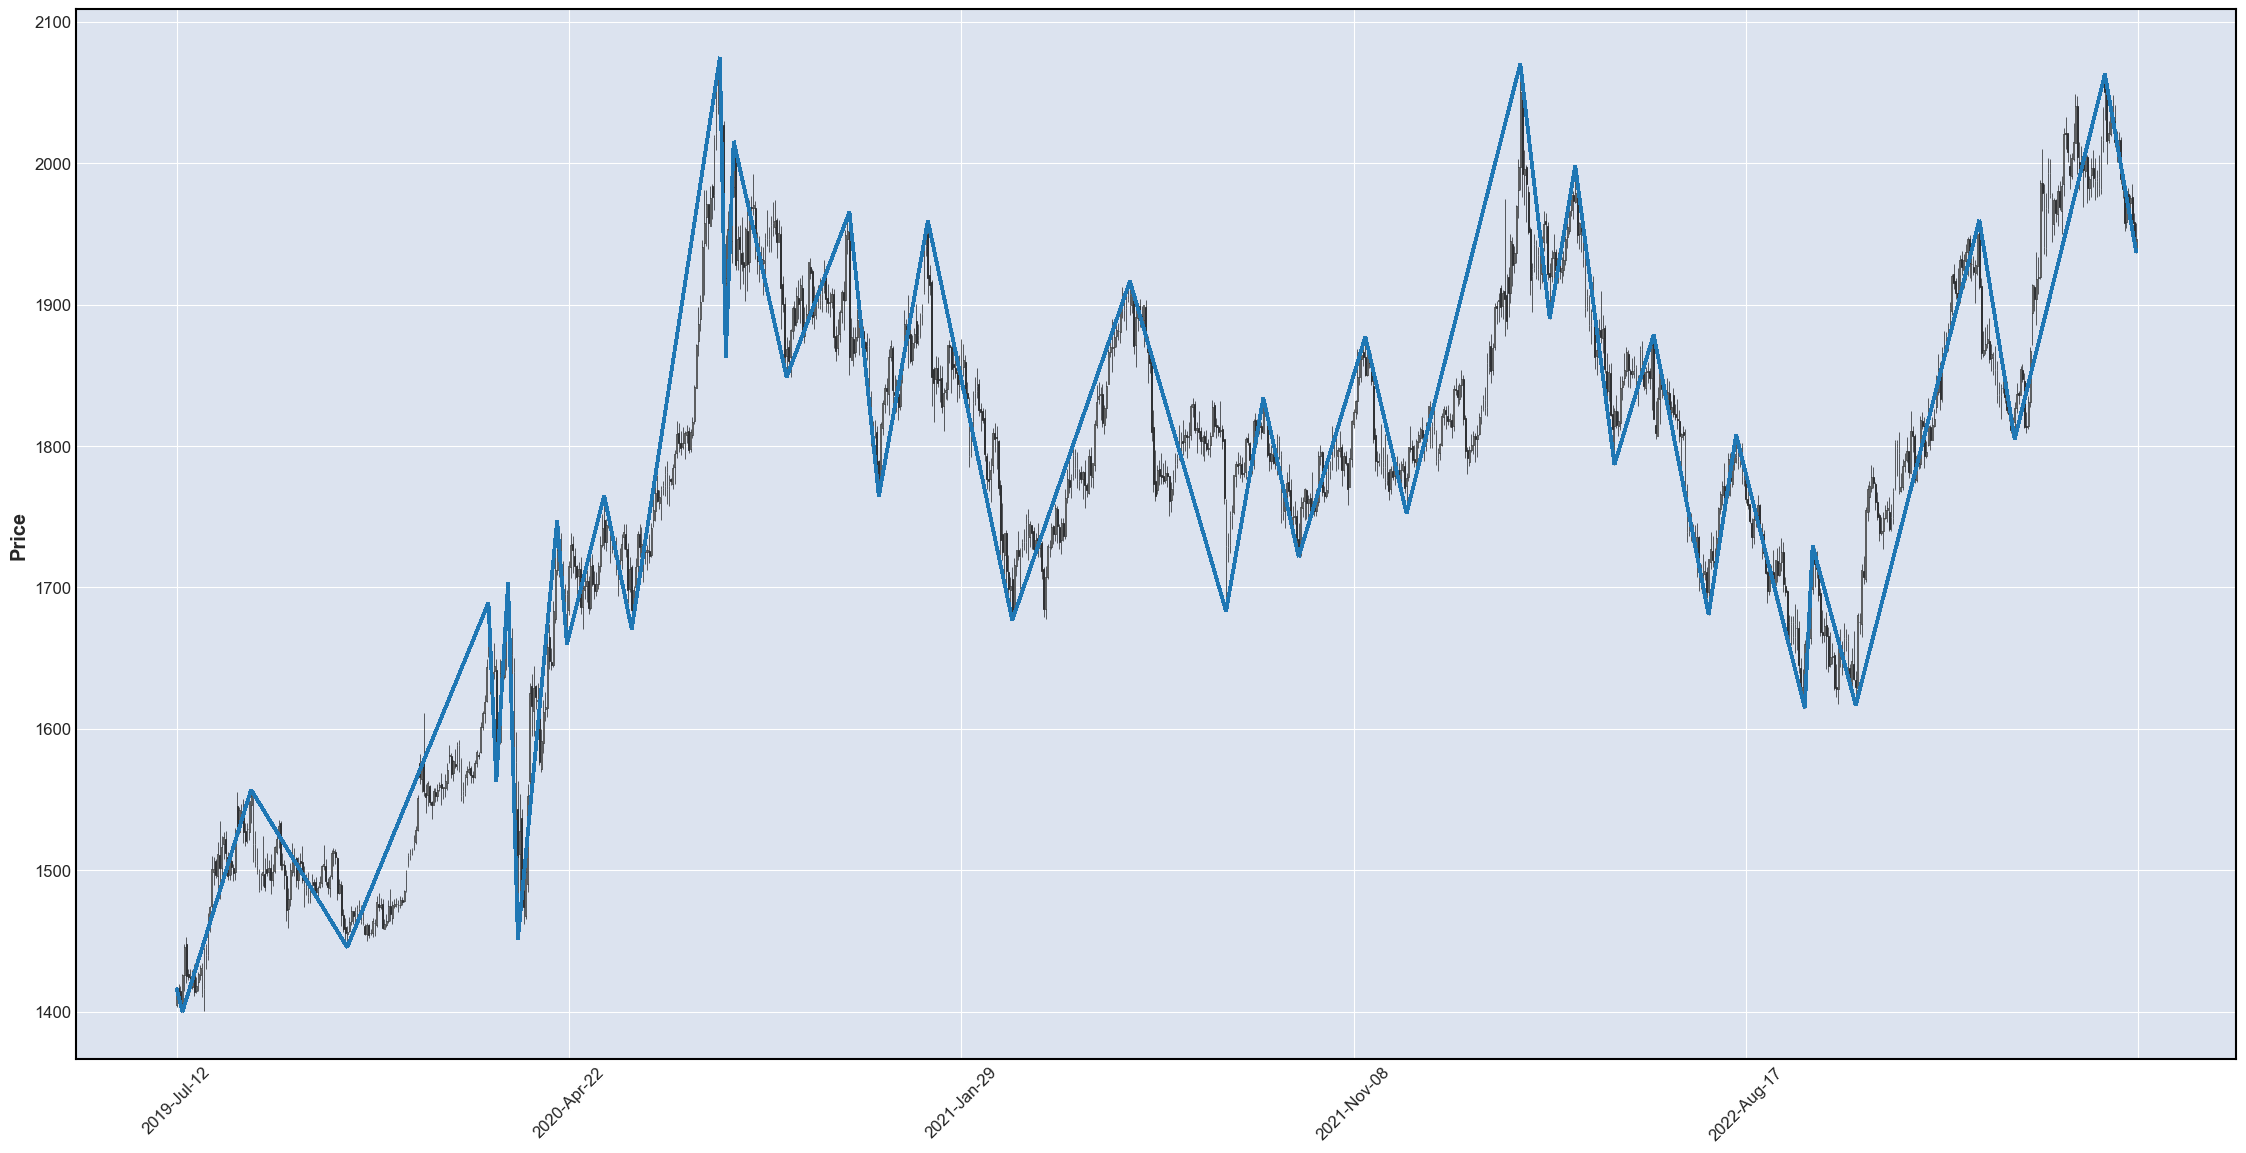

In [17]:
zigzag_visualize(rates_frame_copy)

In [18]:
zigzag_list=zigzag_filter(rates_frame_copy)

In [19]:
zigzag_list['trend'] = np.nan

for i in range(len(zigzag_list)):
    if i==0:
        continue
    elif i==len(zigzag_list)-1:
        break
        
    elif i==1 :
        if zigzag_list.iloc[i , 2] == 'low':
            zigzag_list.iloc[i , 3] = 'down'
            res= zigzag_list.iloc[(i-1) , 1]
            sup= zigzag_list.iloc[i , 1]
        
        else:
            zigzag_list.iloc[i , 3] = 'up'
            res= zigzag_list.iloc[i , 1]
            sup= zigzag_list.iloc[(i-1) , 1]           
        
   
    elif zigzag_list.iloc[(i-1) , 3] == 'down':
        if zigzag_list.iloc[i, 1] > (res + res/100):
            zigzag_list.iloc[i , 3] = 'up'
            res = zigzag_list.iloc[i , 1]
            sup= zigzag_list.iloc[(i-1) , 1]
        
        elif zigzag_list.iloc[i, 2] =='high':
            zigzag_list.iloc[i , 3] = 'down'
            res= zigzag_list.iloc[ i , 1]
        
        elif zigzag_list.iloc[i, 2] =='low':
            zigzag_list.iloc[i , 3] = 'down'
            sup= zigzag_list.iloc[ i , 1] 
            res= zigzag_list.iloc[(i-1) , 1]

        
    elif zigzag_list.iloc[(i-1) , 3] == 'up':
        if zigzag_list.iloc[i, 1] < (sup - sup/100):
            zigzag_list.iloc[i , 3] = 'down'
            res= zigzag_list.iloc[(i-1) , 1]
            sup= zigzag_list.iloc[i , 1]
        
        elif zigzag_list.iloc[i, 2] =='high':
            zigzag_list.iloc[i , 3] = 'up'
            res= zigzag_list.iloc[i , 1]
            sup= zigzag_list.iloc[(i-1) , 1]
        
        elif zigzag_list.iloc[i, 2] =='low':
            zigzag_list.iloc[i , 3] = 'up'
            sup= zigzag_list.iloc[ i , 1]       
            


C:\Anaconda3\lib\site-packages\mplfinance\_arg_validators.py:35: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


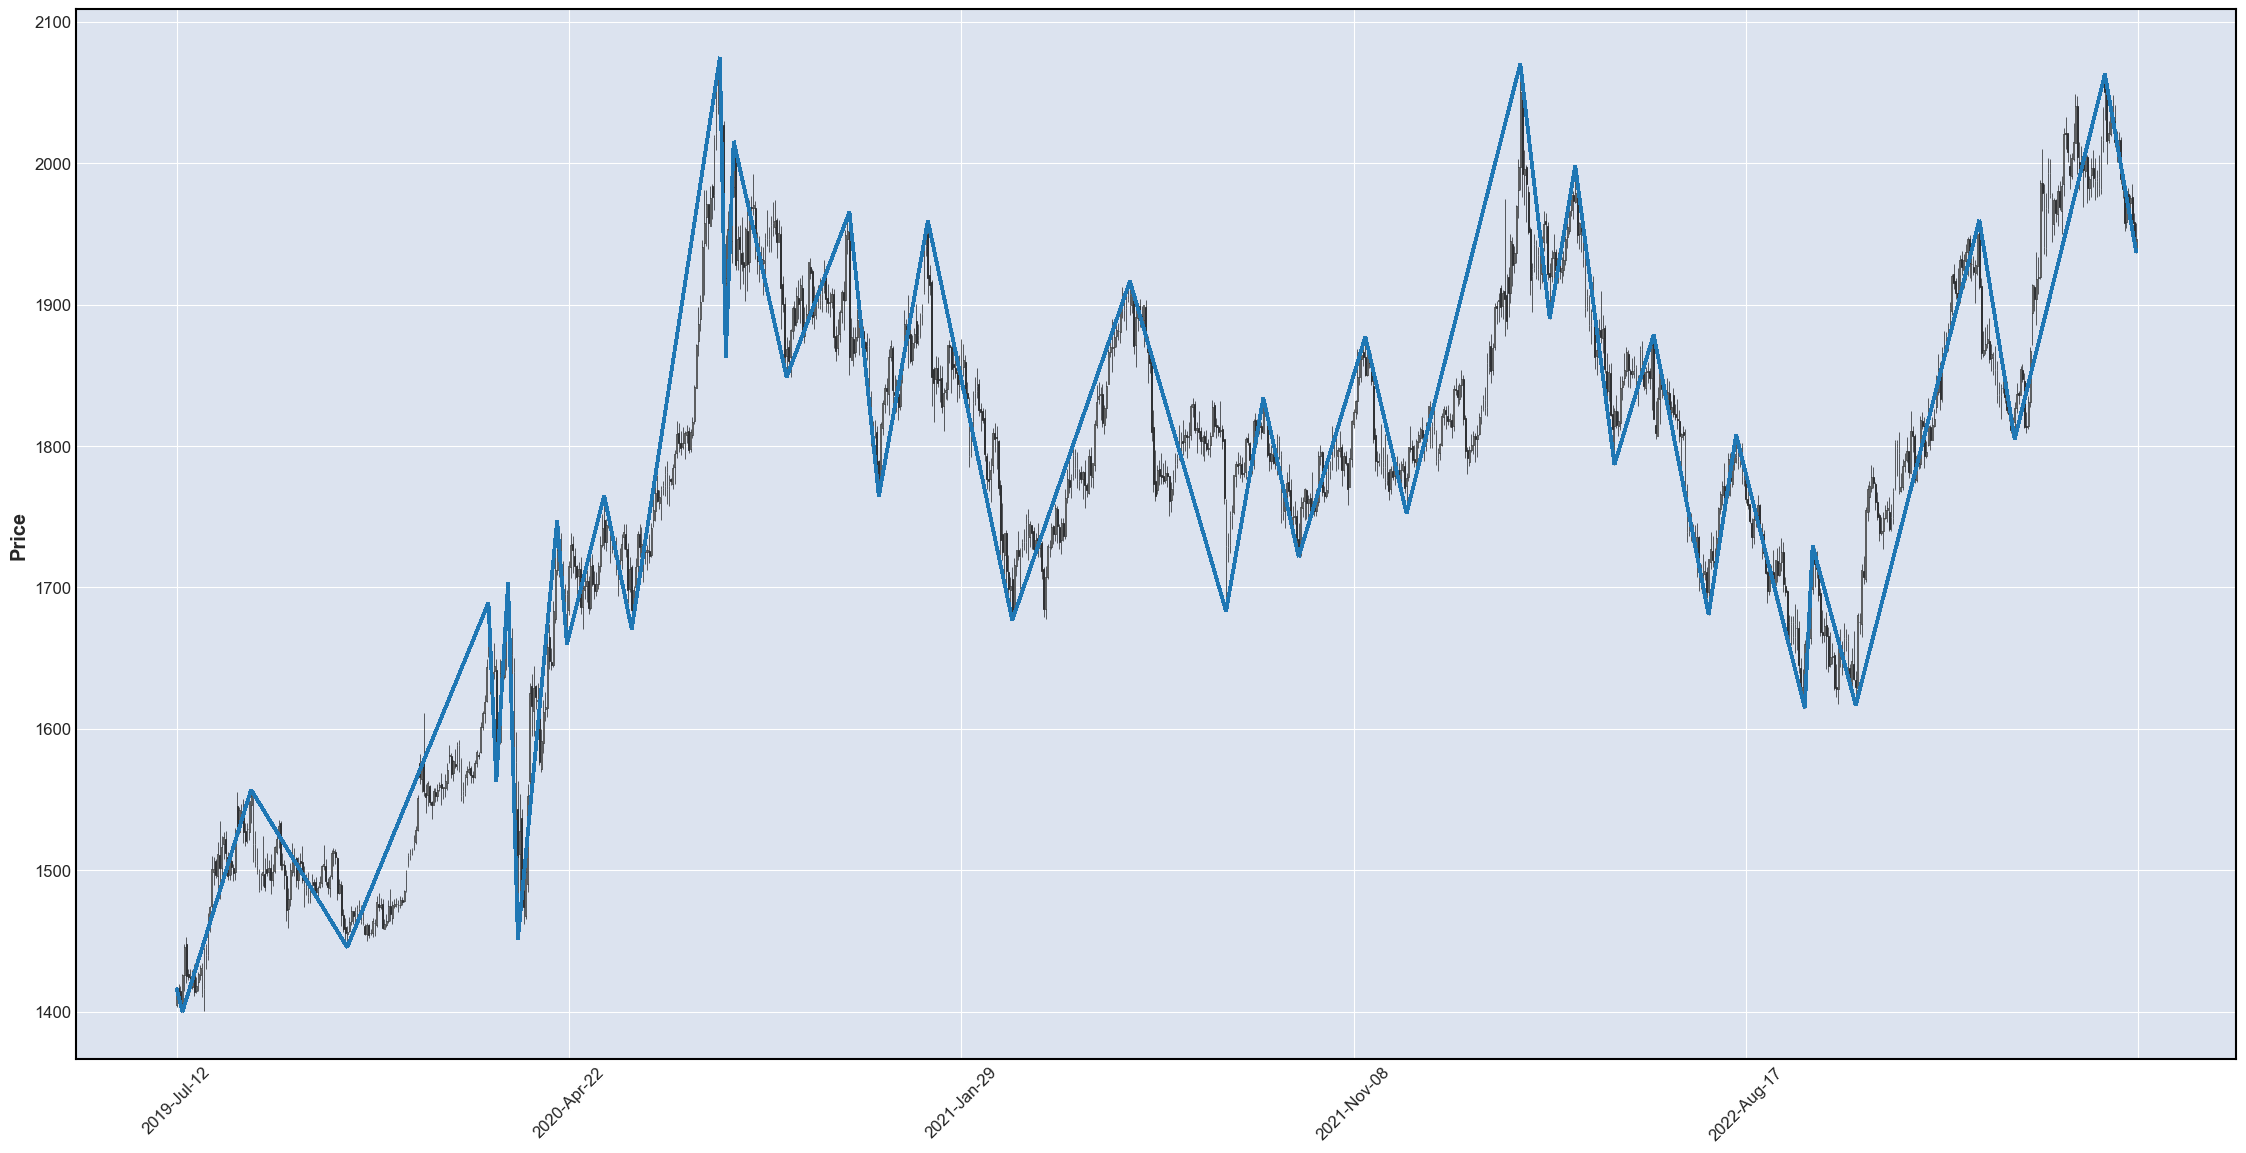

In [20]:
zigzag_visualize(rates_frame_copy)

In [21]:
sup, res

(1804.69, 2062.9)

In [22]:
zigzag_list

,date,price,hl,trend
0,2019-07-12,1416.84,high,NaN
1,2019-07-17,1400.01,low,down
2,2019-09-04,1556.98,high,up
3,2019-11-12,1445.57,low,up
4,2020-02-24,1689.25,high,up
5,2020-02-28,1562.93,low,up
6,2020-03-09,1703.44,high,up
7,2020-03-16,1451.13,low,down
8,2020-04-14,1747.40,high,up
9,2020-04-21,1660.03,low,up


In [23]:
zigzag_list=zigzag_filter(rates_frame_copy)

zigzag_list['date'] = pd.to_datetime(zigzag_list['date']).dt.date


pivot_lines=[]

for i in range(len(zigzag_list)-1):
    lines = [ (str(zigzag_list.iloc[i,0]) , zigzag_list.iloc[i,1]), (str(zigzag_list.iloc[(i+1),0]) , zigzag_list.iloc[(i+1),1]) ]
    pivot_lines.append(lines)
    
two_points = pivot_lines
fplt.plot(dataframe, figratio=(8,4), type='candle', alines=two_points ,figsize=(30,15) )

NameError: name 'dataframe' is not defined

In [24]:
zigzag_list_filtered=pd.DataFrame([], columns=['date','price','hl'])


In [25]:
zigzag_list.loc[0:0]

,date,price,hl
0,2019-07-12,1416.84,high


In [26]:
zigzag_list_filtered=pd.DataFrame([], columns=['date','price','hl'])
for i in range(len(zigzag_list)):
    if i==0:
        zigzag_list_filtered = pd.concat([zigzag_list_filtered, zigzag_list.loc[i:i] ] , axis=0 , ignore_index=True )
        
    elif zigzag_list.iloc[i,2] == 'high' and zigzag_list.iloc[i,1] == rates_frame_copy.loc[ (zigzag_list.iloc[i,0] - BDay(2)) : (zigzag_list.iloc[i,0] + BDay(2)), 'high'].max():
        zigzag_list_filtered=pd.concat([zigzag_list_filtered,zigzag_list.loc[i:i] ] , axis=0 , ignore_index=True) 
    
    elif zigzag_list.iloc[i,2] == 'low' and zigzag_list.iloc[i,1] == rates_frame_copy.loc[ (zigzag_list.iloc[i,0] - BDay(2)) : (zigzag_list.iloc[i,0] + BDay(2)), 'low'].min():
        zigzag_list_filtered=pd.concat([zigzag_list_filtered,zigzag_list.loc[i:i] ] , axis=0 , ignore_index=True) 
    



In [27]:
zigzag_list_filtered

,date,price,hl
0,2019-07-12,1416.84,high
1,2019-07-17,1400.01,low
2,2019-09-04,1556.98,high
3,2019-11-12,1445.57,low
4,2020-02-24,1689.25,high
5,2020-02-28,1562.93,low
6,2020-03-09,1703.44,high
7,2020-03-16,1451.13,low
8,2020-04-14,1747.40,high
9,2020-04-21,1660.03,low


In [28]:
zigzag_list_filtered =zigzag_list 
zigzag_list_filtered['date'] = pd.to_datetime(zigzag_list_filtered['date']).dt.date
zigzag_list_filtered


pivot_lines=[]

for i in range(len(zigzag_list_filtered)-1):
    lines = [ (str(zigzag_list_filtered.iloc[i,0]) , zigzag_list_filtered.iloc[i,1]), (str(zigzag_list_filtered.iloc[(i+1),0]) , zigzag_list_filtered.iloc[(i+1),1]) ]
    pivot_lines.append(lines)
    
two_points = pivot_lines
fplt.plot(dene, figratio=(8,4), type='candle', alines=two_points ,figsize=(30,15) )

NameError: name 'dene' is not defined

In [29]:
rates_frame_copy.index[3] - BDay(1)

Timestamp('2019-07-16 00:00:00')

In [30]:
rates_frame_copy.loc[zigzag_list.iloc[7,0]+ timedelta(days=-4)]

NameError: name 'timedelta' is not defined

In [31]:
import datetime
# BDay is business day, not birthday...
from pandas.tseries.offsets import BDay

today = datetime.datetime.today()
print(today - BDay(4))
today

2023-05-23 00:27:07.902947


datetime.datetime(2023, 5, 28, 0, 27, 7, 902947)

In [32]:
zigzag_list.iloc[7,0]  - BDay(1)

Timestamp('2020-03-13 00:00:00')

In [33]:
rates_frame_copy[rates_frame_copy.index + timedelta(days=1)]

NameError: name 'timedelta' is not defined

In [34]:
zigzag_list

,date,price,hl
0,2019-07-12,1416.84,high
1,2019-07-17,1400.01,low
2,2019-09-04,1556.98,high
3,2019-11-12,1445.57,low
4,2020-02-24,1689.25,high
5,2020-02-28,1562.93,low
6,2020-03-09,1703.44,high
7,2020-03-16,1451.13,low
8,2020-04-14,1747.40,high
9,2020-04-21,1660.03,low


In [35]:
aa

NameError: name 'aa' is not defined

Zigzag Visualization

C:\Anaconda3\lib\site-packages\mplfinance\_arg_validators.py:35: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


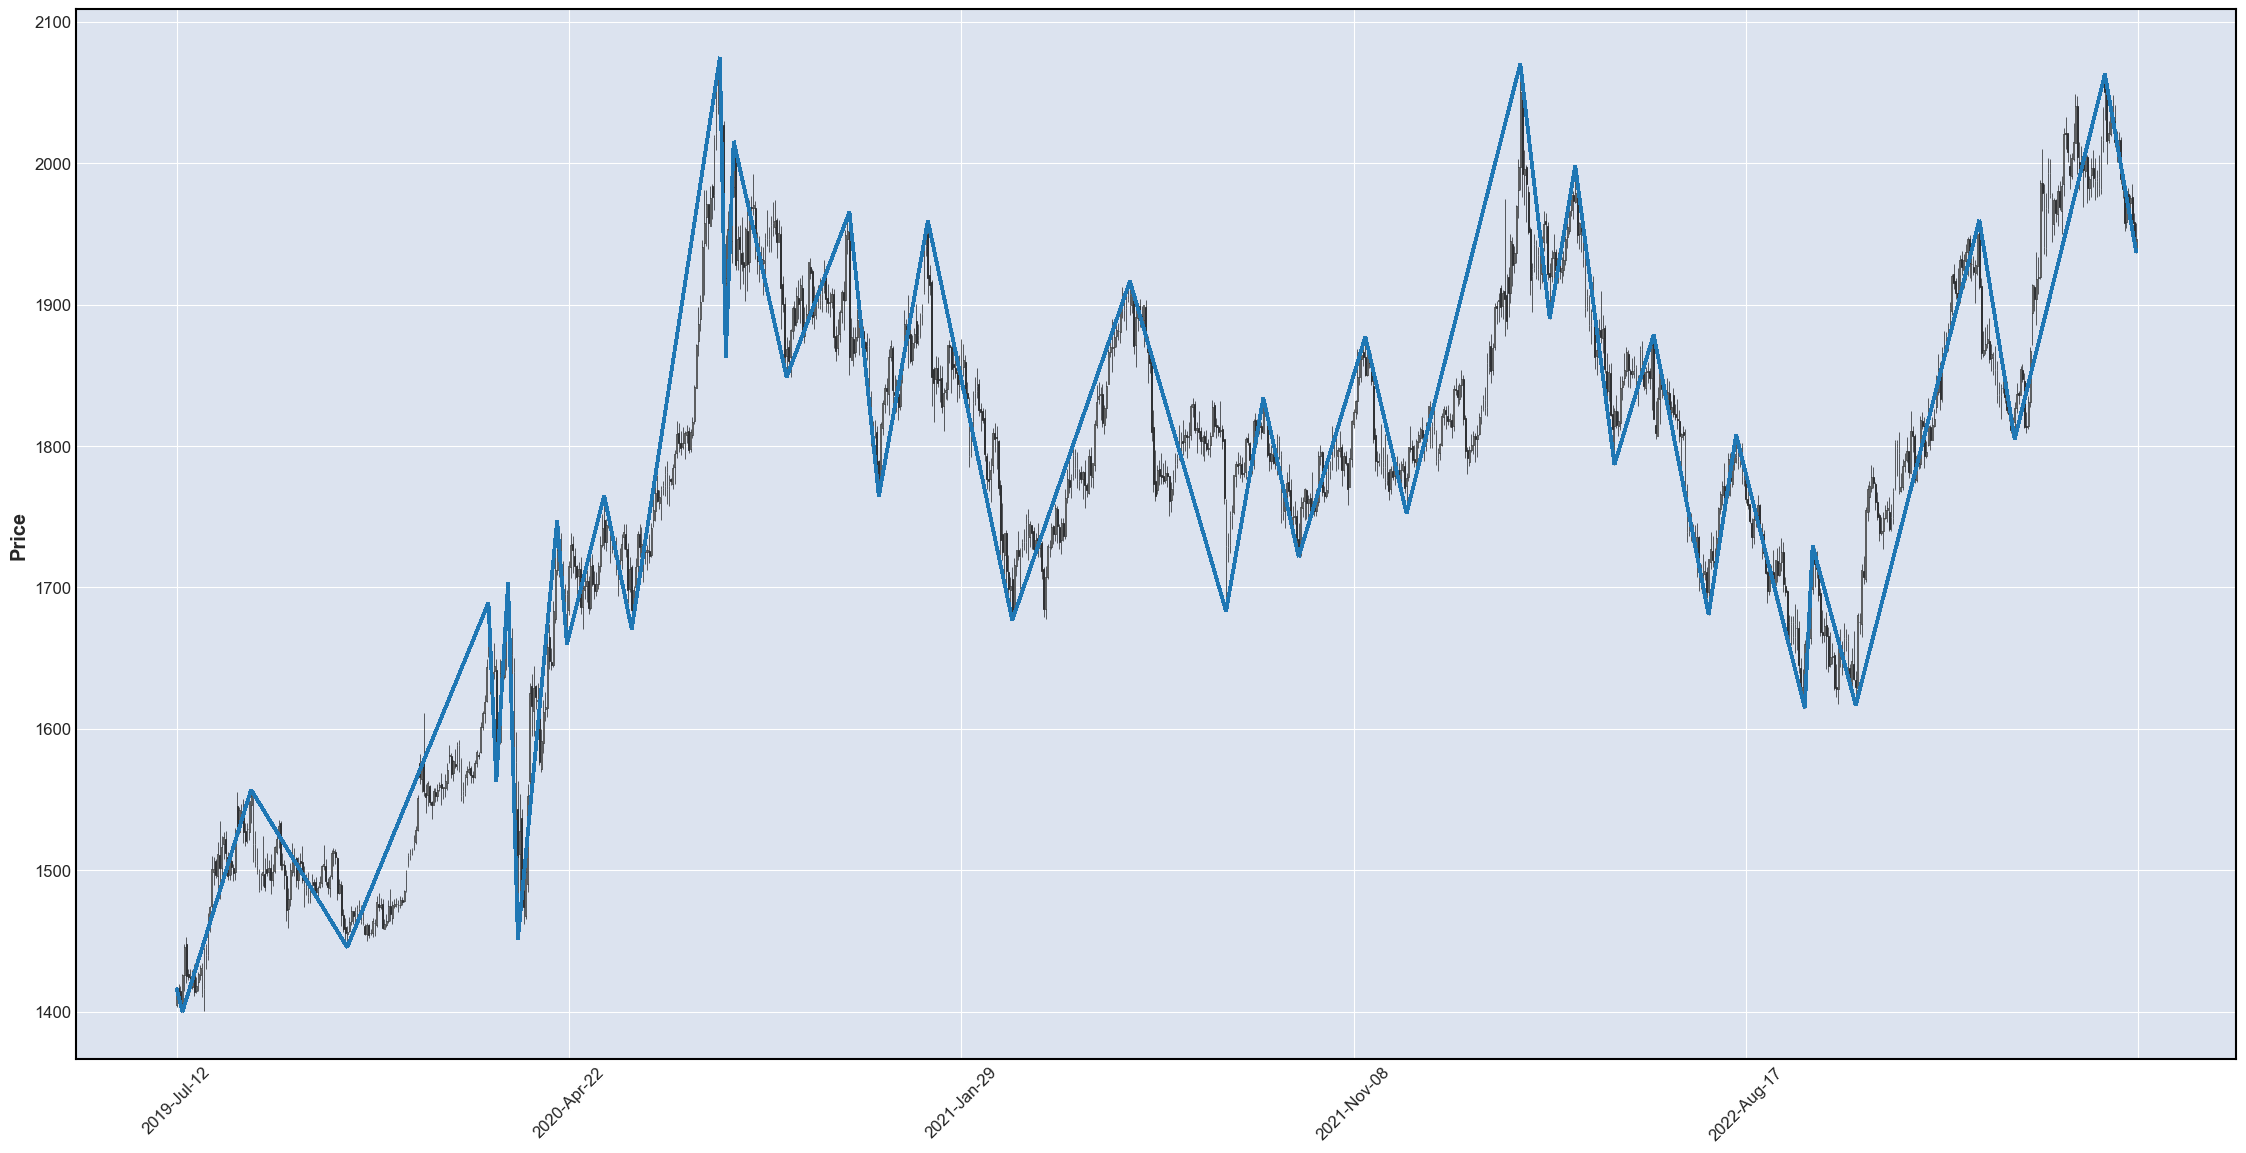

In [36]:
pivot_lines=[]

for i in range(len(zigzag_list)-1):
    lines = [ (str(zigzag_list.iloc[i,0]) , zigzag_list.iloc[i,1]), (str(zigzag_list.iloc[(i+1),0]) , zigzag_list.iloc[(i+1),1]) ]
    pivot_lines.append(lines)
    
two_points = pivot_lines
fplt.plot(rates_frame_copy, figratio=(8,4), type='candle', alines=two_points ,figsize=(30,15))

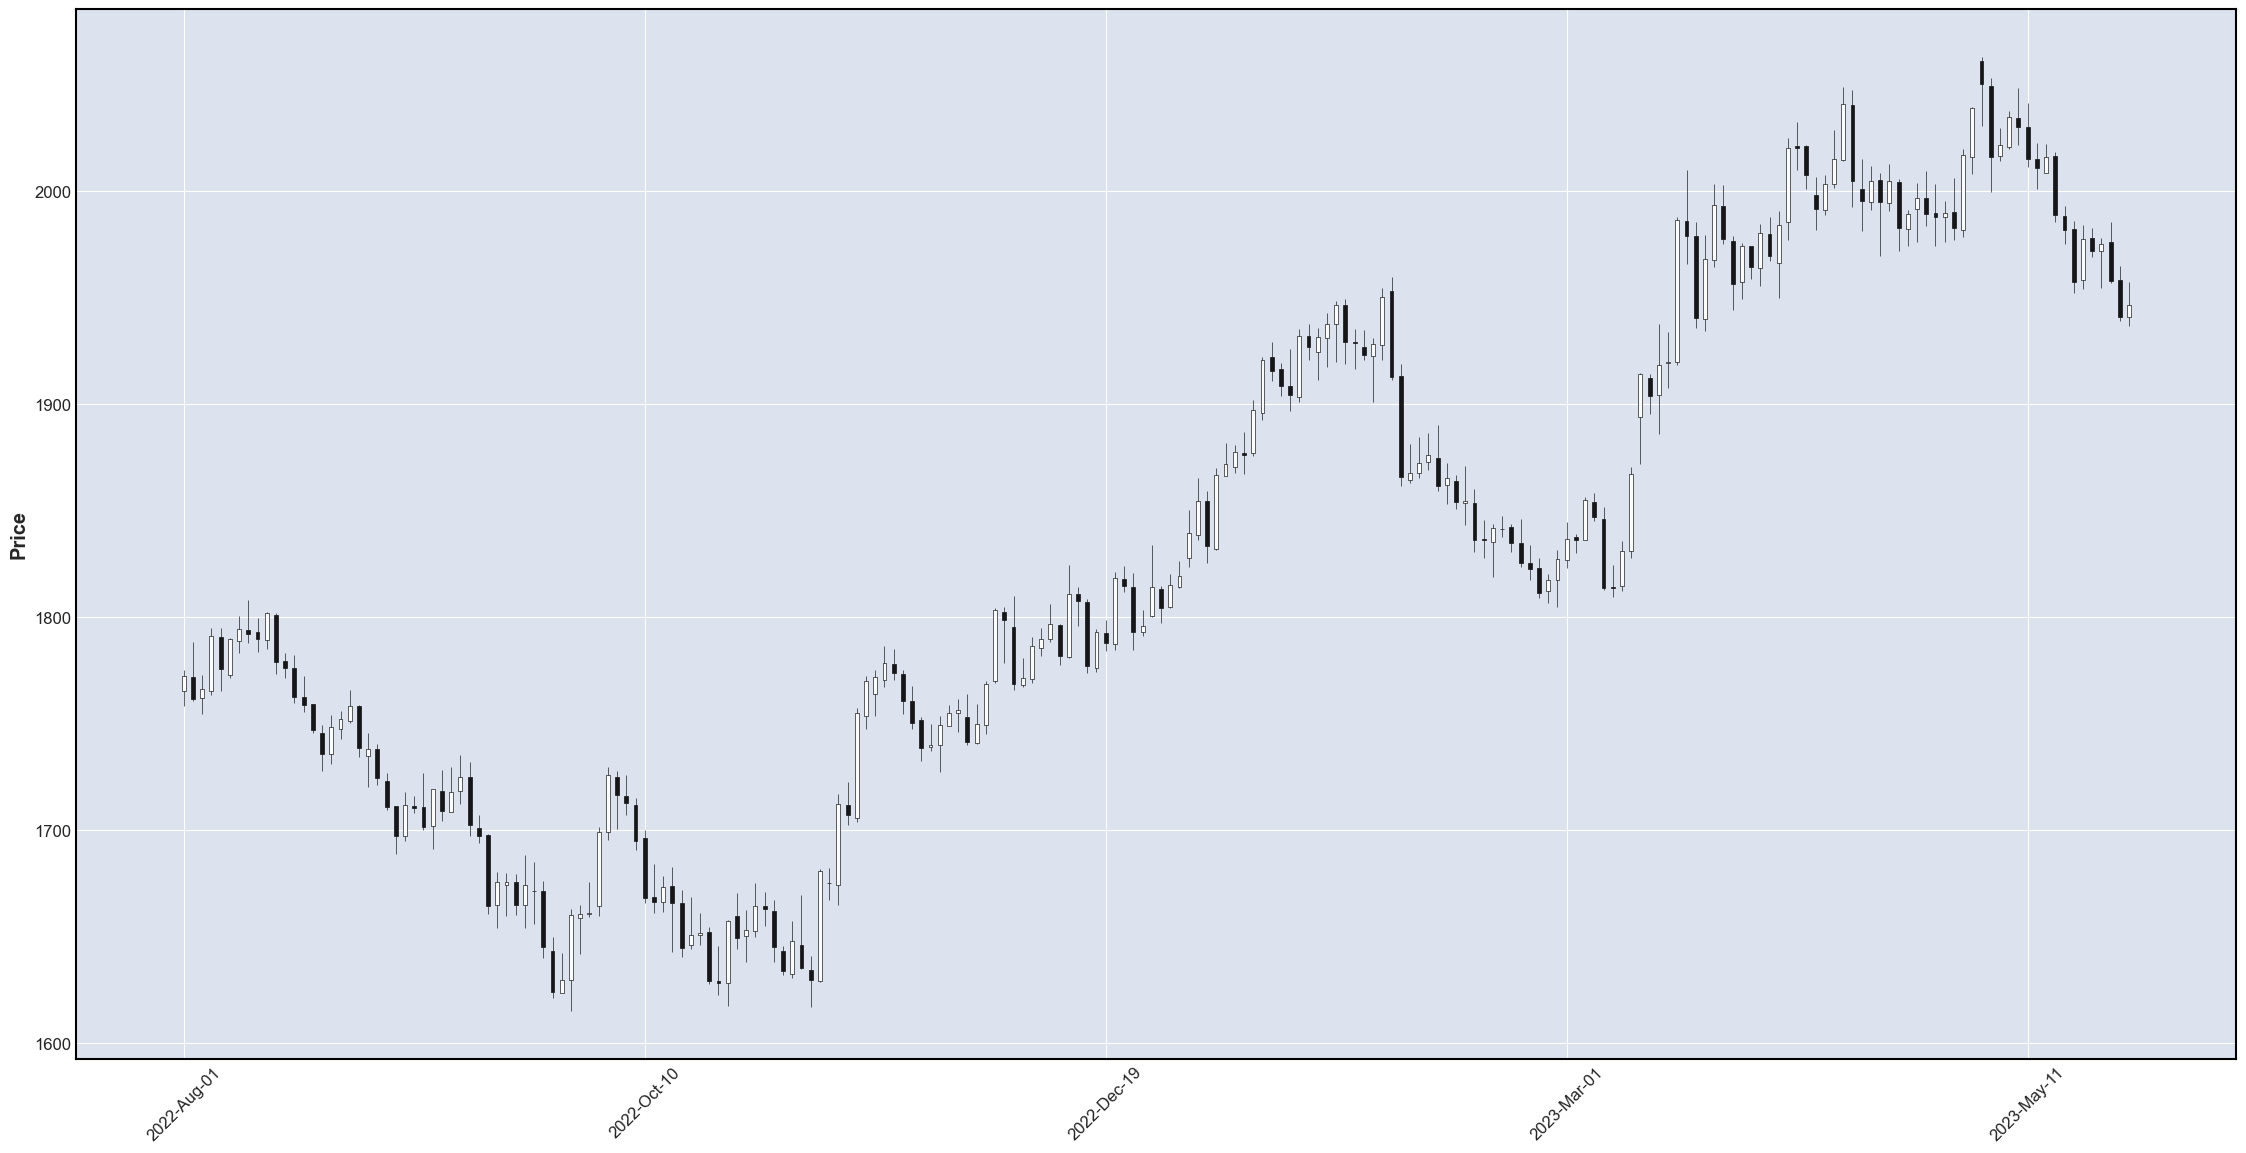

In [37]:
fplt.plot(rates_frame_copy['2022-07-30':], figsize=(30,15) , type='candle')

In [38]:
end_time = datetime.now().strftime('%H:%M:%S')

print('End time:', datetime.now().strftime('%H:%M:%S'))

AttributeError: module 'datetime' has no attribute 'now'

Trend Detection with Zigzag

In [39]:
zigzag_list['trend'] = np.nan
zigzag_list.set_index('date' , inplace= True)

In [40]:
rates_frame_copy =pd.merge(rates_frame_copy, zigzag_list, left_index=True, right_index=True , how='left')

rates_frame_copy

,open,high,low,close,tick_volume,spread,real_volume,ma_close_10,ma_close_20,ma_close_50,ma_close_100,ma_close_200,ema_5,ema_10,ema_20,ema_50,ema_100,ema_200,ma_close_5,ma_close_35,wave,price,hl,trend
btime,,,,,,,,,,,,,,,,,,,,,,,,
2019-07-12,1404.51,1416.84,1403.08,1414.83,53268,15,0,NaN,NaN,NaN,NaN,NaN,1414.830000,1414.830000,1414.830000,1414.830000,1414.830000,1414.830000,NaN,NaN,NaN,1416.84,high,NaN
2019-07-15,1416.52,1419.73,1407.63,1413.70,48080,15,0,NaN,NaN,NaN,NaN,NaN,1414.453333,1414.624545,1414.722381,1414.785686,1414.807624,1414.818756,NaN,NaN,NaN,NaN,NaN,NaN
2019-07-16,1414.44,1418.22,1400.68,1405.82,54713,15,0,NaN,NaN,NaN,NaN,NaN,1411.575556,1413.023719,1413.874535,1414.434091,1414.629651,1414.729216,NaN,NaN,NaN,NaN,NaN,NaN
2019-07-17,1406.48,1426.75,1400.01,1426.21,51546,15,0,NaN,NaN,NaN,NaN,NaN,1416.453704,1415.421225,1415.049341,1414.895891,1414.858965,1414.843453,NaN,NaN,NaN,1400.01,low,NaN
2019-07-18,1426.30,1448.07,1414.56,1445.65,78476,15,0,NaN,NaN,NaN,NaN,NaN,1426.185802,1420.917366,1417.963690,1416.101935,1415.468688,1415.149986,1421.242,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-22,1978.08,1982.59,1968.87,1971.65,119644,5,0,1998.319,2003.6130,1989.4816,1930.1110,1826.43560,1979.068203,1989.962129,1996.171236,1975.948253,1930.688157,1879.017567,1975.396,2003.721143,-1.436621,NaN,NaN,NaN
2023-05-23,1971.64,1977.78,1954.24,1975.16,132916,5,0,1992.390,2002.5390,1990.7054,1931.6709,1827.36325,1977.765469,1987.270832,1994.170166,1975.917341,1931.568788,1879.974208,1972.700,2003.466571,-1.557675,NaN,NaN,NaN
2023-05-24,1976.20,1985.29,1956.71,1957.59,132332,5,0,1985.152,2000.9605,1991.7838,1932.8530,1828.14220,1971.040312,1981.874317,1990.686341,1975.198622,1932.084059,1880.746504,1967.860,2001.677143,-1.727489,NaN,NaN,NaN


C:\Anaconda3\lib\site-packages\mplfinance\_arg_validators.py:35: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


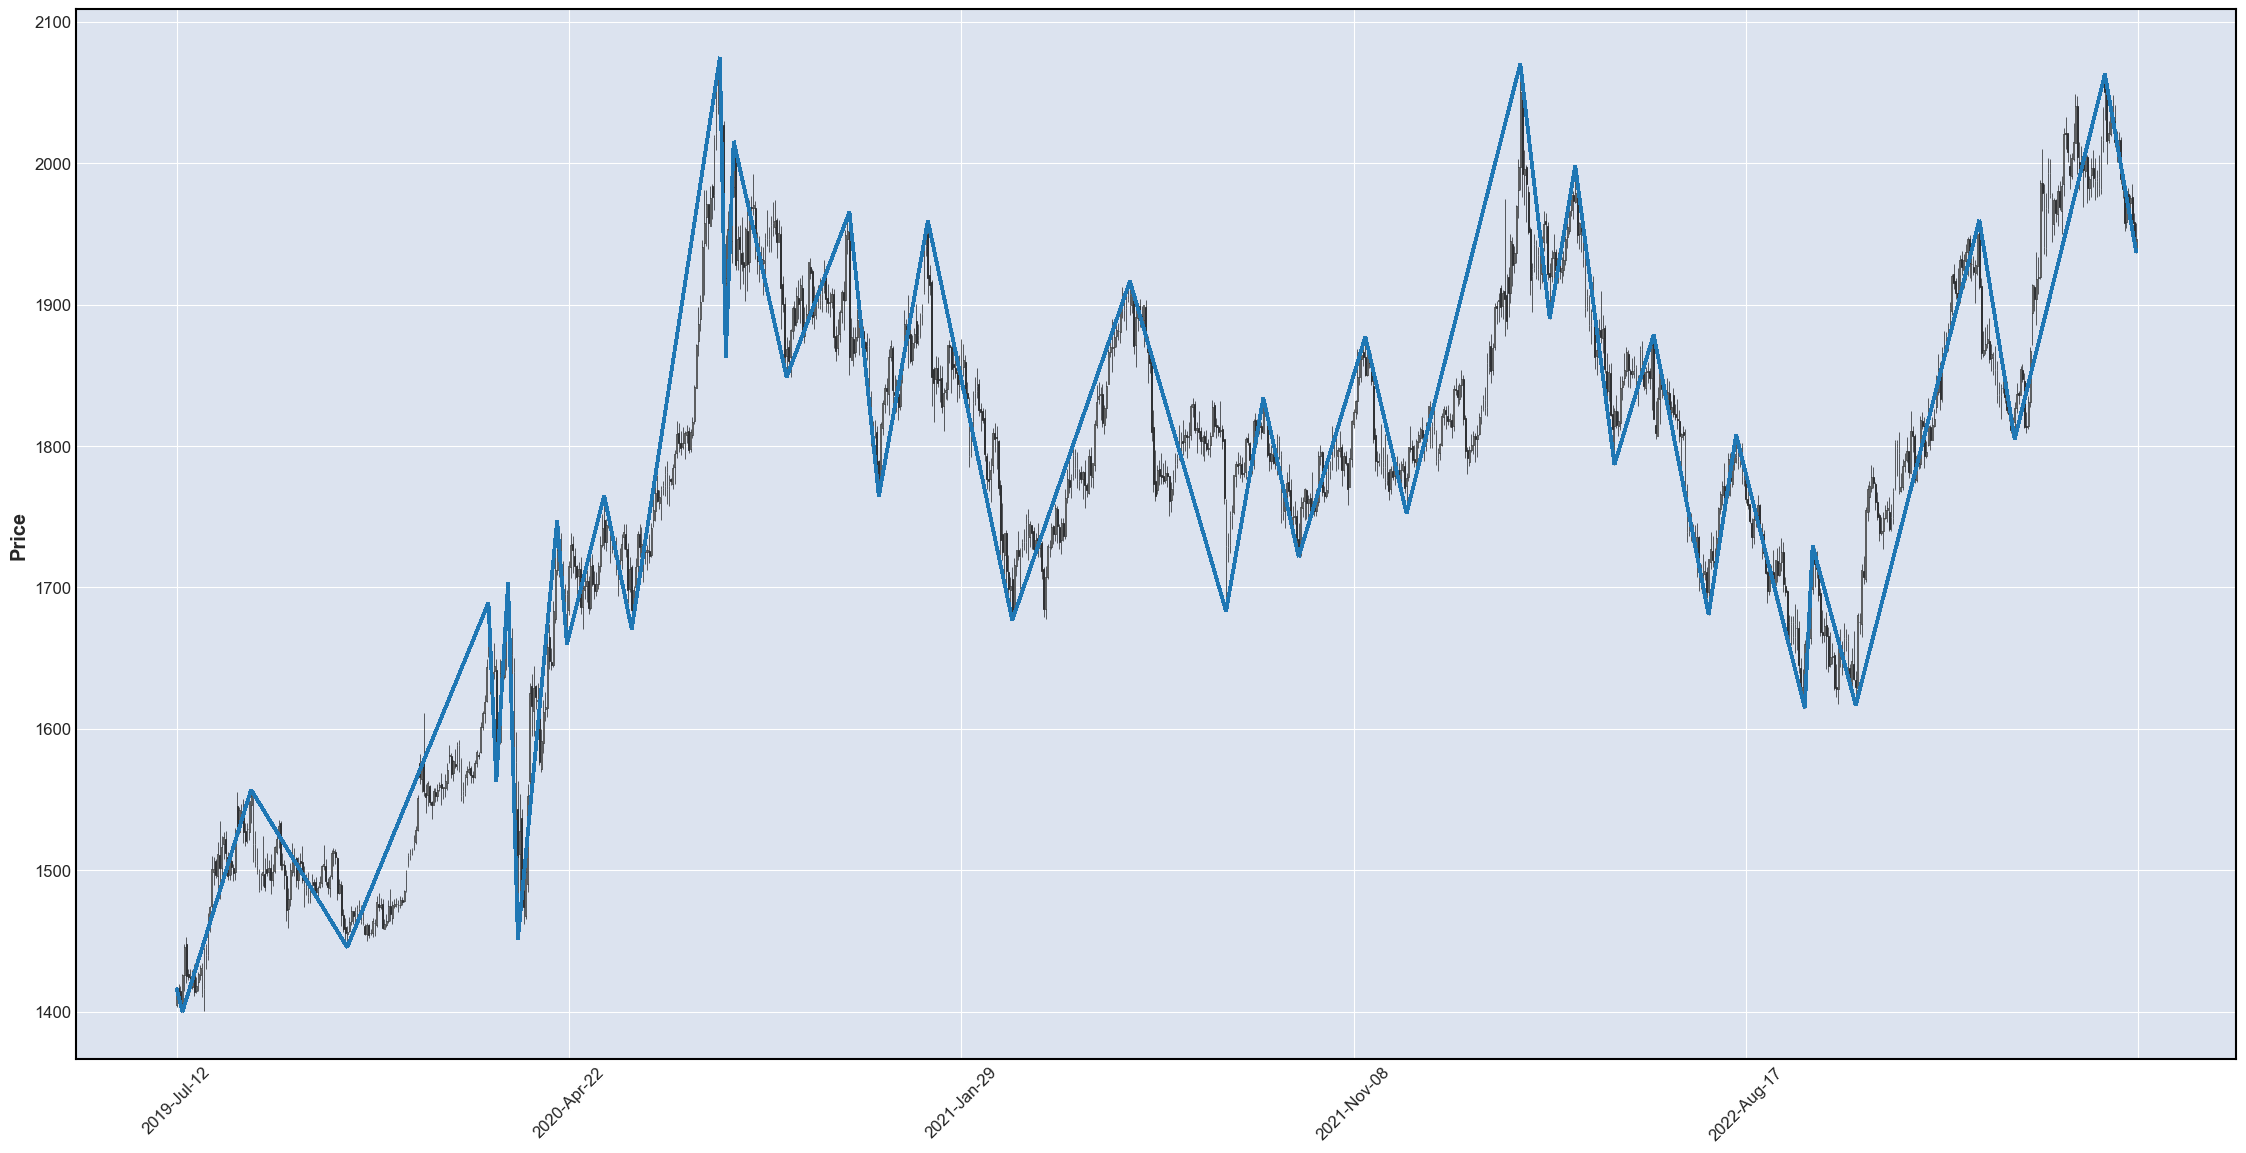

In [41]:
fplt.plot(rates_frame_copy, figratio=(8,4), type='candle', alines=two_points ,figsize=(30,15))

In [42]:
min1_pivot_index=rates_frame_copy[~rates_frame_copy['hl'].isnull()].index[1]
min1_pivot_index

trend_index=min1_pivot_index

In [43]:
rates_frame_copy.loc[rates_frame_copy.index==min1_pivot_index , 'trend'] = rates_frame_copy.loc[rates_frame_copy.index==min1_pivot_index].apply( lambda x : 'up' if x['hl'] == 'high' else 'down', axis=1)


In [44]:
rates_frame_copy.loc[rates_frame_copy.index==min1_pivot_index , 'trend']

btime
2019-07-17    down
Name: trend, dtype: object

In [45]:
rates_frame_copy.loc[:min1_pivot_index , 'trend'] = rates_frame_copy.loc[min1_pivot_index , 'trend']

In [46]:
rates_frame_copy['trend_index'] = np.nan
rates_frame_copy['trend_index'] = np.nan

In [47]:
for i in range(len(rates_frame_copy)):
    if rates_frame_copy.loc[i,-2].index <= min_pivot_index:
        continue
                   
    elif rates_frame_copy.iloc[(i-1),-1] == 'up' and rates_frame_copy.iloc[i,4]<rates_frame_copy.loc[trend_index,'close'] and rates_frame_copy.iloc[i,4]:
        
    
    else:
        rates_frame_copy.iloc[i,-1] == rates_frame_copy.iloc[(i-1),-1]
        
    

IndentationError: expected an indented block (Temp/ipykernel_10704/1539207620.py, line 8)

In [48]:
rates_frame_copy.loc[trend_index,'close']

1426.21

In [49]:
rates_frame_copy.drop(columns= ['trend', 'trend_index'] , inplace=True)

In [50]:
rates_frame_copy.to_csv('xauusdd1.csv' , sep=';')

In [51]:
rates_frame_copy.loc['2022-02-11':]

,open,high,low,close,tick_volume,spread,real_volume,ma_close_10,ma_close_20,ma_close_50,ma_close_100,ma_close_200,ema_5,ema_10,ema_20,ema_50,ema_100,ema_200,ma_close_5,ma_close_35,wave,price,hl
btime,,,,,,,,,,,,,,,,,,,,,,,
2022-02-11,1827.28,1865.45,1820.92,1858.98,134846,5,0,1818.247,1821.4020,1808.0720,1799.7356,1807.15520,1835.188126,1826.373217,1820.757147,1812.861777,1806.559571,1803.170280,1833.022,1816.996000,0.862086,NaN,NaN
2022-02-14,1855.86,1874.16,1850.82,1871.74,145102,5,0,1825.733,1824.0335,1809.8292,1800.9558,1807.35965,1847.372084,1834.621723,1825.612656,1815.170727,1807.850272,1803.852566,1843.274,1818.708000,1.312469,NaN,NaN
2022-02-15,1870.57,1879.51,1844.49,1853.36,111096,5,0,1830.979,1826.0165,1811.3290,1801.9879,1807.44875,1849.368056,1838.028682,1828.255261,1816.668345,1808.751455,1804.345177,1848.740,1820.057429,1.547598,NaN,NaN
2022-02-16,1853.83,1872.57,1850.33,1869.00,101098,5,0,1837.193,1827.4350,1813.0258,1803.3426,1807.60975,1855.912037,1843.659831,1832.135712,1818.720567,1809.944496,1804.988509,1855.966,1821.917429,1.821753,NaN,NaN
2022-02-17,1869.85,1901.13,1867.81,1898.25,136437,5,0,1846.530,1830.3710,1815.3410,1805.0605,1808.02045,1870.024692,1853.585316,1838.432311,1821.839368,1811.693119,1805.916484,1870.266,1824.293714,2.421825,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-22,1978.08,1982.59,1968.87,1971.65,119644,5,0,1998.319,2003.6130,1989.4816,1930.1110,1826.43560,1979.068203,1989.962129,1996.171236,1975.948253,1930.688157,1879.017567,1975.396,2003.721143,-1.436621,NaN,NaN
2023-05-23,1971.64,1977.78,1954.24,1975.16,132916,5,0,1992.390,2002.5390,1990.7054,1931.6709,1827.36325,1977.765469,1987.270832,1994.170166,1975.917341,1931.568788,1879.974208,1972.700,2003.466571,-1.557675,NaN,NaN
2023-05-24,1976.20,1985.29,1956.71,1957.59,132332,5,0,1985.152,2000.9605,1991.7838,1932.8530,1828.14220,1971.040312,1981.874317,1990.686341,1975.198622,1932.084059,1880.746504,1967.860,2001.677143,-1.727489,NaN,NaN


In [52]:
str(zigzag_list.iloc[1].name)

'2019-07-17'

In [53]:
zigzag_list=  pd.merge( zigzag_list,rates_frame_copy[['open', 'high' , 'low' ,'close']], left_index=True, right_index=True , how='left')
zigzag_list

,price,hl,trend,open,high,low,close
date,,,,,,,
2019-07-12,1416.84,high,NaN,1404.51,1416.84,1403.08,1414.83
2019-07-17,1400.01,low,NaN,1406.48,1426.75,1400.01,1426.21
2019-09-04,1556.98,high,NaN,1546.53,1556.98,1533.78,1552.60
2019-11-12,1445.57,low,NaN,1454.99,1460.32,1445.57,1456.30
2020-02-24,1689.25,high,NaN,1659.37,1689.25,1650.83,1658.50
2020-02-28,1562.93,low,NaN,1641.91,1649.46,1562.93,1584.70
2020-03-09,1703.44,high,NaN,1695.92,1703.44,1657.41,1678.15
2020-03-16,1451.13,low,NaN,1543.04,1562.94,1451.13,1509.09
2020-04-14,1747.40,high,NaN,1712.25,1747.40,1708.56,1726.54


In [54]:
for index, row in zigzag_list.iterrows():
    print(index)
    break

2019-07-12 00:00:00


In [55]:
from datetime import timedelta

In [56]:
zigzag_list.iloc[0]

price    1416.84
hl          high
trend        NaN
open     1404.51
high     1416.84
low      1403.08
close    1414.83
Name: 2019-07-12 00:00:00, dtype: object

In [57]:
str(zigzag_list.iloc[0].name)

'2019-07-12 00:00:00'

In [58]:
trend=' '
sup=' '
res=' '

for index, row in zigzag_list.iloc.iterrows():
    
    if index==zigzag_list.iloc[0].name:
        continue
        
    elif index==zigzag_list.iloc[1].name:
        
        if row['hl']== 'high':
            trend ='bull'
            
            res = [row['high'], max(row['close'], row['open']) ]
            
            index_loc = zigzag_list.index.get_loc(index)            
            sup = [zigzag_list.iloc[index_loc-1]['low'], min(zigzag_list.iloc[index_loc-1]['open'],zigzag_list.iloc[index_loc-1]['close'] )]
        
        else:
            trend = 'bear'
            
            index_loc = zigzag_list.index.get_loc(index)  
            res=  [zigzag_list.iloc[index_loc-1]['high'], max(zigzag_list.iloc[index_loc-1]['open'],zigzag_list.iloc[index_loc-1]['close'] )]
            
            sup= [row['low'], min(row['close'], row['open']) ]
            
        
    elif trend=='bull' and row['close'] > res[0]:
        if (row['close']-res[0])/res[0] < 0.015:
            res = [row['high'] , max(row['close'], row['open'])]
            
            index_loc = zigzag_list.index.get_loc(index)            
            sup = [zigzag_list.iloc[index_loc-1]['low'], min(zigzag_list.iloc[index_loc-1]['open'],zigzag_list.iloc[index_loc-1]['close'] )
    
    (row['close']-res[0])/res[0] >= 0.015


SyntaxError: unexpected EOF while parsing (Temp/ipykernel_10704/2499748137.py, line 36)

C:\Anaconda3\lib\site-packages\mplfinance\_arg_validators.py:35: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


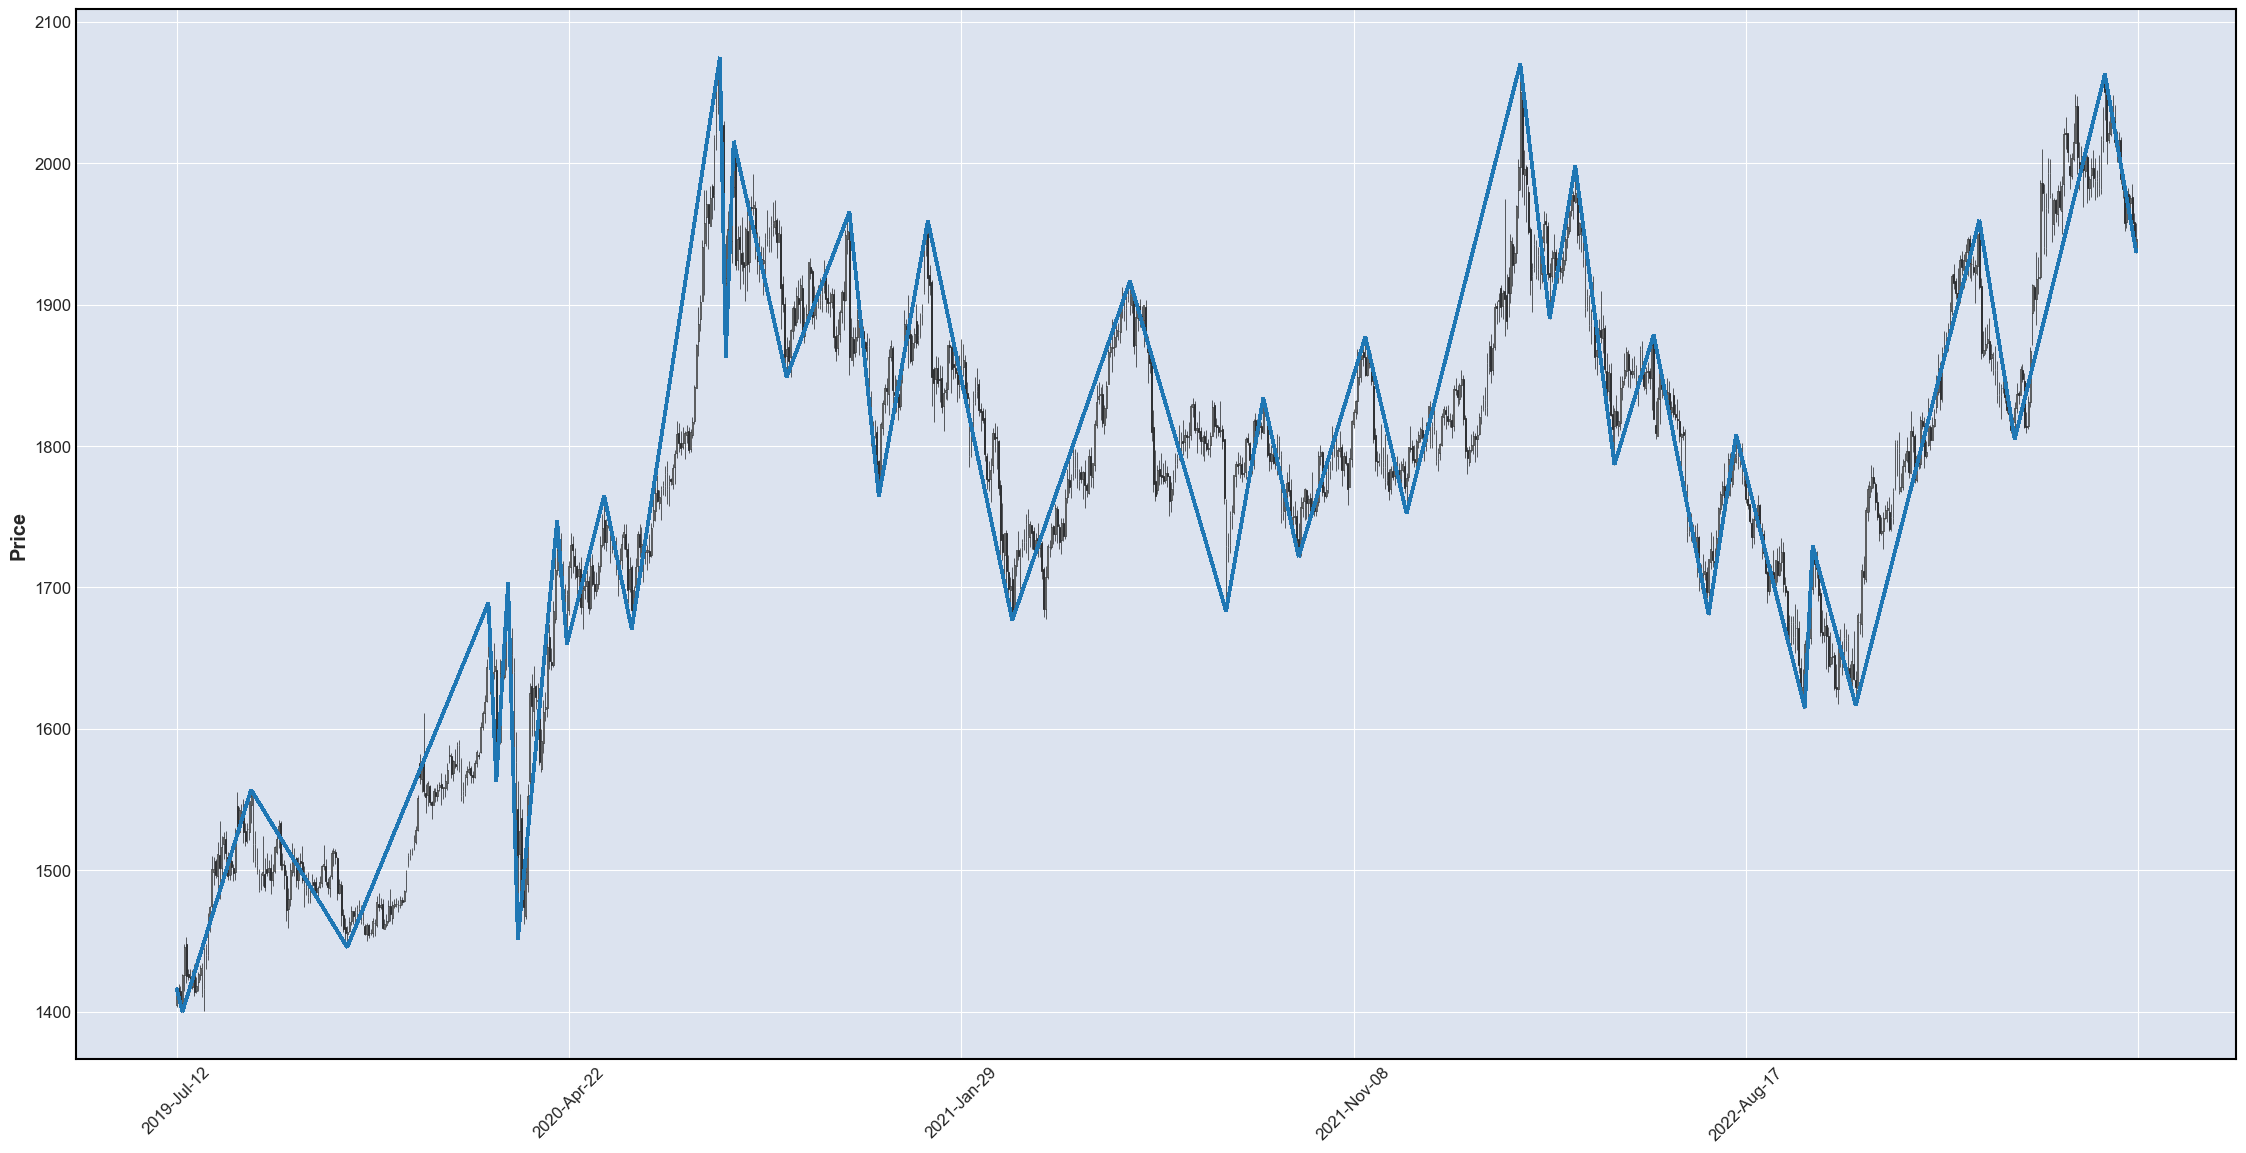

In [59]:
fplt.plot(rates_frame_copy, figratio=(8,4), type='candle', alines=two_points ,figsize=(30,15))
